# <p style="text-align: center;">Data Loading for TP1 - Did you see that sign?</p>

### **1. Import the Required Libraries**

In [2]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
%matplotlib inline
from PIL import Image 
import os
import re
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import random

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
def set_seeds(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds(0)

### **2. Load the Image Training and Test Datasets**

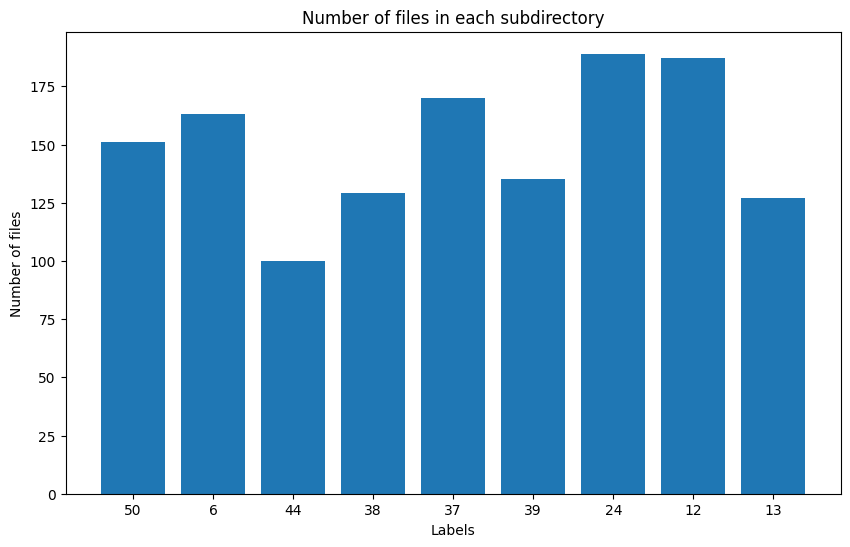

In [4]:
def count_files_in_subdirectories(directory_path):
    count_dict = {}
    for root, dirs, files in os.walk(directory_path):
        for dir in dirs:
            dir_path = os.path.join(root, dir)
            file_count = len([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])
            count_dict[dir] = file_count
    return count_dict

train_dataset_path = 'data-students/TRAIN/'
count_dict = count_files_in_subdirectories(train_dataset_path)

# Plotting
labels = list(count_dict.keys())
counts = list(count_dict.values())

plt.figure(figsize=(10,6))
plt.bar(labels, counts)
plt.xlabel('Labels')
plt.ylabel('Number of files')
plt.title('Number of files in each subdirectory')
plt.show()

#### **i. Get the Image Dataset Paths**

In [5]:
train_dataset_path = 'data-students/TRAIN/'
test_dataset_path = 'data-students/TEST'

#### ii. Load Image Datasets 

In [6]:
IMG_WIDTH = 75
IMG_HEIGHT = 75
BATCH_SIZE = 4

#### calculate mean and std for train and kaggle test

https://www.youtube.com/watch?v=lu7TCu7HeYc&t=1138s

In [20]:
# transform = transforms.Compose([transforms.Resize((IMG_WIDTH, IMG_HEIGHT)), transforms.ToTensor()])
# dataset = datasets.ImageFolder(train_dataset_path, transform=transform)

# # Create a dataloader
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

# # Variables to store sum of all pixel values and square of pixel values for each color channel
# sum_total = np.zeros(3)
# sum_square_total = np.zeros(3)
# num_batches = 0

# for images, _ in dataloader:
#     # Flatten the tensor image
#     numpy_image = images.numpy()

#     # Sum of all pixel values for each color channel
#     sum_total += numpy_image.sum(axis=(0, 2, 3))
#     sum_square_total += np.sum(np.square(numpy_image), axis=(0, 2, 3))
#     num_batches += 1

# # Total number of pixels in the dataset for each color channel
# num_pixels = num_batches * IMG_WIDTH * IMG_HEIGHT

# # Calculate mean and std for each color channel
# mean = sum_total / num_pixels
# std = np.sqrt((sum_square_total / num_pixels) - (mean * mean))

# print(f"Mean: {mean}")
# print(f"Std: {std}")

Mean: [0.38408771 0.37468079 0.34759176]
Std: [0.22151036 0.2185382  0.23466401]


In [11]:
# transform = transforms.Compose([transforms.Resize((IMG_WIDTH, IMG_HEIGHT)), transforms.ToTensor()])
# test_dataset = TestDataset(images_folder=test_dataset_path, transform=transform)

# # Create a dataloader
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# # Variables to store sum of all pixel values and square of pixel values for each color channel
# sum_total = np.zeros(3)
# sum_square_total = np.zeros(3)
# num_batches = 0

# for images in test_dataloader:
#     # Flatten the tensor image
#     numpy_image = images.numpy()

#     # Sum of all pixel values for each color channel
#     sum_total += numpy_image.sum(axis=(0, 2, 3))
#     sum_square_total += np.sum(np.square(numpy_image), axis=(0, 2, 3))
#     num_batches += 1

# # Total number of pixels in the dataset for each color channel
# num_pixels = num_batches * IMG_WIDTH * IMG_HEIGHT

# # Calculate mean and std for each color channel
# mean = sum_total / num_pixels
# std = np.sqrt((sum_square_total / num_pixels) - (mean * mean))

# print(f"Mean: {mean}")
# print(f"Std: {std}")

Mean: [0.42458388 0.42566059 0.42005094]
Std: [0.26857187 0.28247367 0.31355321]


### load dataset

In [7]:
transform = transforms.Compose([transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
                                transforms.ToTensor(), 
                                transforms.Normalize(mean = [0.38408771, 0.37468079, 0.34759176], std= [0.22151036, 0.2185382,  0.23466401]) 
                                 ])
dataset = datasets.ImageFolder(train_dataset_path, transform=transform)

#### Loading the test dataset.

In [17]:
transform = transforms.Compose([
    transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.42458388, 0.42566059, 0.42005094], std=[0.26857187, 0.28247367, 0.31355321])
    ])

class TestDataset(Dataset):
    def get_int(self, text):
        return [int(c) if c.isdigit() else c for c in re.split('(\d+)', text)]
    
    def __init__(self, images_folder, transform=None):
        self.images_folder = images_folder
        self.image_files = [f for f in os.listdir(images_folder) if os.path.isfile(os.path.join(images_folder, f))]
        self.image_files.sort(key=self.get_int)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

inference_dataset = TestDataset(images_folder=test_dataset_path, transform=transform)

test_dataset_loader = DataLoader(inference_dataset, batch_size=BATCH_SIZE, shuffle=False)

#### **iii. Get the Label Mappings**

The labels dictionary is made in order to retrive the class names against the label indices used for training the model

In [16]:
### subset version
#the_labels = {value for _, value in train_datagen.class_to_idx.items()}
labels = {value: key for key, value in dataset.class_to_idx.items()}
print(labels)
the_real_labels = {}
with open("data-students/labels.csv","r") as label_f:
    for line in label_f.readlines()[1:]:
        label_value, label_description = line.strip().split(";")
        the_real_labels[int(label_value)] = label_description 

print(the_real_labels)

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value} - {the_real_labels[int(value)]}")
the_labels_map = {key: value for key, value in dataset.class_to_idx.items()}
print(len(labels))

{0: '12', 1: '13', 2: '24', 3: '37', 4: '38', 5: '39', 6: '44', 7: '50', 8: '6'}
{6: 'Speed limit (70km/h)', 12: 'Dont Go Left or Right', 13: 'Dont Go Right', 24: 'Go Right', 37: 'Children crossing', 38: 'Dangerous curve to the right', 39: 'Dangerous curve to the left', 44: 'Go left or straight', 50: 'Fences'}
Label Mappings for classes present in the training and validation datasets

0 : 12 - Dont Go Left or Right
1 : 13 - Dont Go Right
2 : 24 - Go Right
3 : 37 - Children crossing
4 : 38 - Dangerous curve to the right
5 : 39 - Dangerous curve to the left
6 : 44 - Go left or straight
7 : 50 - Fences
8 : 6 - Speed limit (70km/h)
9


the code above was adapted from:

João Correia, João Macedo, Nuno Lourenço. (2024). AML-2024-Project1. Kaggle. https://kaggle.com/competitions/aml-2024-project1

### Helper Functions

In [12]:
# the accuracy metrics function has been reused from a previous work that i co-authored
def calculate_accuracy_metrics(y_true, y_pred):
    """ Calculate accuracy metrics (confusion matrix, precision, recall, f1)
    and print them (if print_results is True). If write_to_dict is not None,
    then the metrics are also written to the dictionary. """
    cm = confusion_matrix(y_true, y_pred, normalize='all', labels=np.unique(y_true))
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    #print the confusion matrix
    plt.matshow(cm, cmap='Blues')
    # annotate the confusion matrix
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if cm[i, j] > 0:
                plt.text(x=j, y=i, s=round(cm[i, j], 3), va='center', ha='center', size='small')
    # add the class names to the axes
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    labels = np.unique(y_true)
    plt.xticks(range(len(labels)), labels)
    plt.yticks(range(len(labels)), labels)
    plt.show()
    print(f"Precision: {prec:.2f}, Recall: {rec:.2f}, F1: {f1:.2f}\n")
    return


def export_preds(test_dataset_loader, model, labels):
    # Ensure the model is in evaluation mode
    model.eval()

    # List to store predictions
    predictions = []

    # wrap in no_grad to save memory
    with torch.no_grad():
        for imgs in test_dataset_loader:
            imgs = imgs.to(device)

            # Get the model's predictions
            outputs = model(imgs)

            # Convert the output probabilities to predicted class
            preds = torch.argmax(outputs, dim=1)

            # Append batch prediction to the list of predictions
            predictions.extend(preds.cpu().numpy())

    # Convert list to numpy array
    predictions_np = np.array(predictions)

    # Convert numpy array to DataFrame
    df = pd.DataFrame(predictions_np, columns=['TARGET'])

    # Since the file names are the IDs in this case, you can directly use them
    ids = range(1, len(predictions_np) + 1)

    # Add IDs to DataFrame
    df['ID'] = ids

    # Reorder columns to have 'ID' first
    df = df[['ID', 'TARGET']]

    #RECONVERT THE LABELS
    df['TARGET'] = df['TARGET'].map(labels)

    # Convert all columns of DataFrame to integer
    df = df.astype(int)

    # Save DataFrame to .csv
    df.to_csv('predictions.csv', index=False)

    # Save DataFrame as Excel file
    df.to_excel('predictions.xlsx', index=False)

    df.head()

    return df

# IMPLEMENT MLP

## MLP 1 - K-Fold - Adam

#### Perform Train Test split before K-fold

In [24]:
# Create x and y tensors
x, y = zip(*[(img, label) for img, label in dataset]) # zip combines images and labels
x = torch.stack(x)
y = torch.tensor(y)

# Split the data
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.2) #STRATIFY

# Load images to tensors
X = torch.Tensor(x_train)
y = torch.Tensor(y_train)

# Print the shapes
print("Split Sizes TT (80%-20%):")
print(f"Train: {x_train.shape}, {y_train.shape}")
print(f"Test: {x_test.shape}, {y_test.shape}")

Split Sizes TT (80%-20%):
Train: torch.Size([1076, 3, 75, 75]), torch.Size([1076])
Test: torch.Size([270, 3, 75, 75]), torch.Size([270])


#### Train the Model

Fold: 1, Epoch: 0, Training Loss: 2.234633684158325, Validation Loss: 2.170933723449707
Fold: 1, Epoch: 10, Training Loss: 1.8759779930114746, Validation Loss: 1.880102276802063
Fold: 1, Epoch: 20, Training Loss: 1.4823328256607056, Validation Loss: 1.5329984426498413
Fold: 1, Epoch: 30, Training Loss: 1.2522693872451782, Validation Loss: 1.3659189939498901
Fold: 1, Epoch: 40, Training Loss: 1.0615161657333374, Validation Loss: 1.1358871459960938
Fold: 1, Epoch: 50, Training Loss: 0.9130922555923462, Validation Loss: 1.0010058879852295
Fold: 1, Epoch: 60, Training Loss: 0.7809877395629883, Validation Loss: 0.9002520442008972
Fold: 1, Epoch: 70, Training Loss: 0.681134819984436, Validation Loss: 0.7807761430740356
Fold: 1, Epoch: 80, Training Loss: 0.5835887789726257, Validation Loss: 0.6813121438026428
Fold: 1, Epoch: 90, Training Loss: 0.4937566816806793, Validation Loss: 0.6063538193702698
Fold: 1, Epoch: 100, Training Loss: 0.4951825439929962, Validation Loss: 0.5827587842941284
Fol

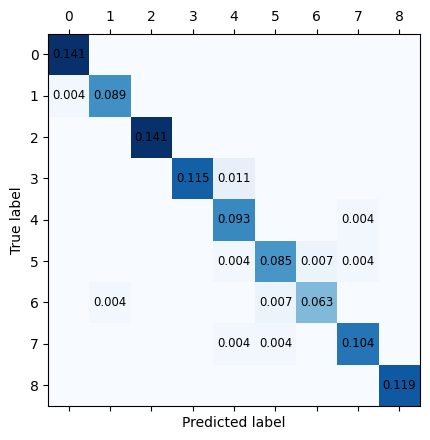

Precision: 0.95, Recall: 0.95, F1: 0.95



In [29]:
# Initialize lists to store the metrics for each fold
precisions = []
recalls = []
f1_scores = []

kf = KFold(n_splits=5)  # Define the split into 5 folds

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(16875, 90),
        nn.ReLU(),

        nn.Linear(90, 90),
        nn.ReLU(),

        nn.Linear(90, 90),
        nn.ReLU(),

        nn.Linear(90, 30),
        nn.Sigmoid(),

        nn.Linear(30, 9),
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=0.002, weight_decay=0.0001)
    loss_fn = torch.nn.CrossEntropyLoss()
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

    num_epochs = 6000
    patience = 60
    best_loss = float('inf')
    epochs_no_improve = 0

    for n in range(num_epochs):
        # Training
        model.train()
        y_pred = model(X_train) # obtain preds
        loss = loss_fn(y_pred, y_train.long()) # predictions with actual labels, converted to .int634
        optimizer.zero_grad()
        loss.backward() #backward pass
        optimizer.step() # update weights

        # Validation
        model.eval()
        with torch.no_grad():
            y_val_pred = model(X_val)
            val_loss_epoch = loss_fn(y_val_pred, y_val.long())

            if n % 10 == 0:
                print(f'Fold: {fold+1}, Epoch: {n}, Training Loss: {loss.item()}, Validation Loss: {val_loss_epoch.item()}')

            # Get the predicted classes
            _, predicted = torch.max(y_val_pred.data, 1) #maximum prob value

            # Calculate the weighted precision, recall, and F1 score
            prec = precision_score(y_val.numpy(), predicted.numpy(), average='weighted', zero_division=0)
            rec = recall_score(y_val.numpy(), predicted.numpy(), average='weighted', zero_division=0)
            f1 = f1_score(y_val.numpy(), predicted.numpy(), average='weighted', zero_division=0)

            # Append the metrics to the lists
            precisions.append(prec)
            recalls.append(rec)
            f1_scores.append(f1)

            # Early stopping
            if val_loss_epoch < best_loss:
                best_loss = val_loss_epoch
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
                if epochs_no_improve == patience:
                    print('Early stopping!')
                    break

    print(f'Best validation loss for fold {fold+1}: {best_loss.item()}')

# Testing
model.eval()
X_test = torch.Tensor(x_test)
y_test = torch.Tensor(y_test)
test_predictions = torch.argmax(model(X_test), dim=1)

# Calculate the mean and standard deviation of the metrics
prec_mean, prec_std = np.mean(precisions), np.std(precisions)
rec_mean, rec_std = np.mean(recalls), np.std(recalls)
f1_mean, f1_std = np.mean(f1_scores), np.std(f1_scores)
print('Validation test results:')
print(f'Precision: mean = {prec_mean:.2f}, std = {prec_std:.2f}')
print(f'Recall: mean = {rec_mean:.2f}, std = {rec_std:.2f}')
print(f'F1 score: mean = {f1_mean:.2f}, std = {f1_std:.2f}')

calculate_accuracy_metrics(y_test, test_predictions)

61.9% no kaggle 

## MLP 2 - MSELoss

#### Train-Validation-Test split

In [24]:
# Create x and y tensors
x, y = zip(*[(img, label) for img, label in dataset])
x = torch.stack(x)
y = torch.tensor(y)

# Split data into train, validation, and test sets (40%-30%-30%)
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, stratify=y, test_size=0.3) # STRATIFY
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, stratify=y_train_val, test_size=0.42857)

# Print the shapes
print("Split Sizes TVT (40%-30%-30%):")
print(f"Train: {x_train.shape}, {y_train.shape}")
print(f"Validation: {x_val.shape}, {y_val.shape}")
print(f"Test: {x_test.shape}, {y_test.shape}")

Split Sizes TVT (40%-30%-30%):
Train: torch.Size([538, 3, 75, 75]), torch.Size([538])
Validation: torch.Size([404, 3, 75, 75]), torch.Size([404])
Test: torch.Size([404, 3, 75, 75]), torch.Size([404])


In [25]:
def convert_and_one_hot_encode(y, num_classes):
    y_tensor = torch.Tensor(y).long()
    return torch.nn.functional.one_hot(y_tensor, num_classes).float()

num_classes = 9

y_train1 = convert_and_one_hot_encode(y_train, num_classes)
y_val1 = convert_and_one_hot_encode(y_val, num_classes)
y_test1 = convert_and_one_hot_encode(y_test, num_classes)

#### Train the Model

Epoch: 0, Training Loss: 0.10908445715904236, Validation Loss: 0.10702846944332123
Epoch: 10, Training Loss: 0.0519651398062706, Validation Loss: 0.047721028327941895
Epoch: 20, Training Loss: 0.033003319054841995, Validation Loss: 0.030257301405072212
Epoch: 30, Training Loss: 0.022332925349473953, Validation Loss: 0.02121686190366745
Epoch: 40, Training Loss: 0.01578781194984913, Validation Loss: 0.01554181706160307
Epoch: 50, Training Loss: 0.011941674165427685, Validation Loss: 0.013461967930197716
Epoch: 60, Training Loss: 0.009906197898089886, Validation Loss: 0.012379198335111141
Epoch: 70, Training Loss: 0.008294019848108292, Validation Loss: 0.01147400215268135
Epoch: 80, Training Loss: 0.007474615704268217, Validation Loss: 0.010722851380705833
Epoch: 90, Training Loss: 0.0069593810476362705, Validation Loss: 0.01040300540626049
Epoch: 100, Training Loss: 0.0057293749414384365, Validation Loss: 0.009869690053164959
Epoch: 110, Training Loss: 0.005045370664447546, Validation L

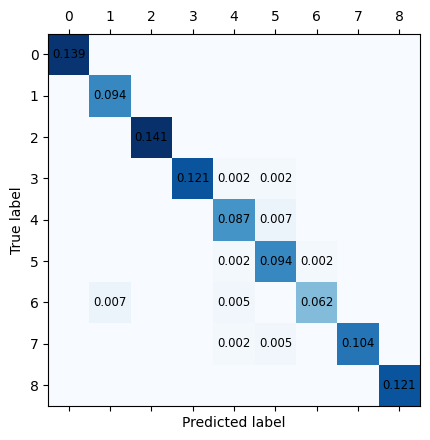

Precision: 0.97, Recall: 0.96, F1: 0.96



In [137]:
val_loss2 =[]
train_loss2 = []

model = nn.Sequential(
    nn.Flatten(),  
    nn.Linear(16875, 150),  
    nn.LeakyReLU(),  #Leaky
    nn.Dropout(0.2), 

    nn.Linear(150, 150), 
    nn.LeakyReLU(),  
    nn.Dropout(0.1), 

    nn.Linear(150, 500), 
    nn.LeakyReLU(), 
    nn.Dropout(0.1), 

    nn.Linear(500, 150),  
    nn.LeakyReLU(),  
    nn.Dropout(0.05), 

    nn.Linear(150, 25),  
    nn.Tanh(),          #### TAHN
    nn.Dropout(0.01), 

    nn.Linear(25, 9), 
)

optimizer = torch.optim.RMSprop(model.parameters(), lr=0.0001)
loss_fn = torch.nn.MSELoss()

num_epochs = 10000
patience = 10
best_loss = float('inf')
epochs_no_improve = 0

for n in range(num_epochs):
    # Training
    model.train()
    y_pred = model(x_train)
    loss = loss_fn(y_pred, y_train1) 
    train_loss2.append(loss.item())  # Append training loss for this epoch
    optimizer.zero_grad()
    loss.backward() #backpropagation
    optimizer.step() # update parameters

    # Validation
    model.eval()
    with torch.no_grad():
        y_val_pred = model(x_val)
        val_loss_epoch = loss_fn(y_val_pred, y_val1)
        val_loss2.append(val_loss_epoch.item())  # Append validation loss for this epoch

    if n % 10 == 0:
        print(f'Epoch: {n}, Training Loss: {loss.item()}, Validation Loss: {val_loss_epoch.item()}')

    # Early stopping
    if val_loss_epoch < best_loss:
        best_loss = val_loss_epoch
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print('Early stopping!')
            break

print(n, loss.item())

#Testing
model.eval()
test_predictions2 = torch.argmax(model(x_test), dim=1).float()  # Convert the one-hot encoded predictions to a single integer

# Convert y_test to the same format as test_predictions
y_test_argmax = torch.argmax(y_test1, dim=1)

calculate_accuracy_metrics(y_test_argmax, test_predictions2)

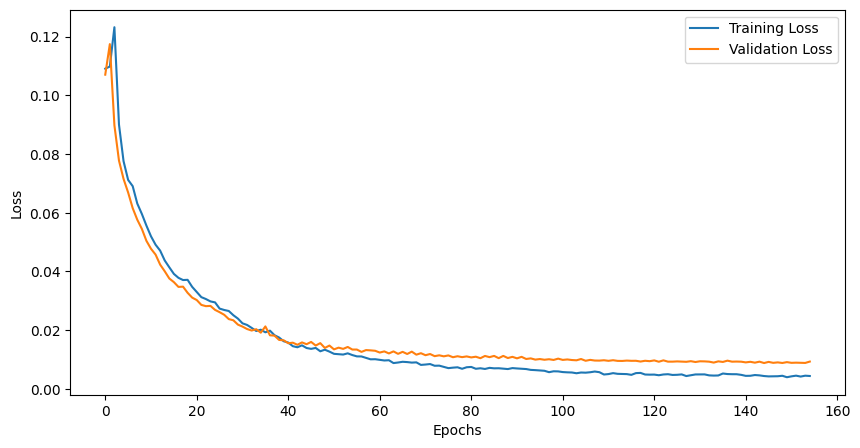

In [142]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss2, label='Training Loss')
plt.plot(val_loss2, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

kaggle score 51%

## MLP 3 - PCA - Adadelta

#### PCA

In [134]:
# Reshape the data to two dimensions
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_val_flat = x_val.reshape(x_val.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

# Apply PCA
pca = PCA(0.95)
pca.fit(x_train_flat)

x_train_pca = pca.transform(x_train_flat)
x_val_pca = pca.transform(x_val_flat)
x_test_pca = pca.transform(x_test_flat)

#DO the same to Kaggle test data
# Get all images from the DataLoader
kaggle_images = [img for img in test_dataset_loader]

# Convert list of batches into a single tensor
kaggle_images_tensor = torch.cat(kaggle_images)

# Reshape the tensor to two dimensions
kaggle_images_flat = kaggle_images_tensor.view(kaggle_images_tensor.shape[0], -1)

# Convert tensor to numpy array
kaggle_images_np = kaggle_images_flat.numpy()

# Apply PCA transformation
kaggle_test_pca = pca.transform(kaggle_images_np)

# Convert numpy array to tensor
kaggle_test_pca_tensor = torch.from_numpy(kaggle_test_pca).float()

x_train_pca.shape # (samples, features)


(538, 108)

In [135]:
num_features_PCA = x_train_pca.shape[1]
num_features_PCA

108

#### Train the Model

Epoch: 0, Training Loss: 2.2659573554992676, Validation Loss: 2.2653441429138184
Epoch: 10, Training Loss: 2.2645797729492188, Validation Loss: 2.264103651046753
Epoch: 20, Training Loss: 2.2630200386047363, Validation Loss: 2.262918710708618
Epoch: 30, Training Loss: 2.261653184890747, Validation Loss: 2.2615320682525635
Epoch: 40, Training Loss: 2.260122537612915, Validation Loss: 2.260207414627075
Epoch: 50, Training Loss: 2.258807420730591, Validation Loss: 2.2589550018310547
Epoch: 60, Training Loss: 2.2572526931762695, Validation Loss: 2.2573325634002686
Epoch: 70, Training Loss: 2.25573468208313, Validation Loss: 2.255899429321289
Epoch: 80, Training Loss: 2.2540178298950195, Validation Loss: 2.2540879249572754
Epoch: 90, Training Loss: 2.252631664276123, Validation Loss: 2.252810001373291
Epoch: 100, Training Loss: 2.2511327266693115, Validation Loss: 2.2511587142944336
Epoch: 110, Training Loss: 2.2492473125457764, Validation Loss: 2.249584436416626
Epoch: 120, Training Loss: 

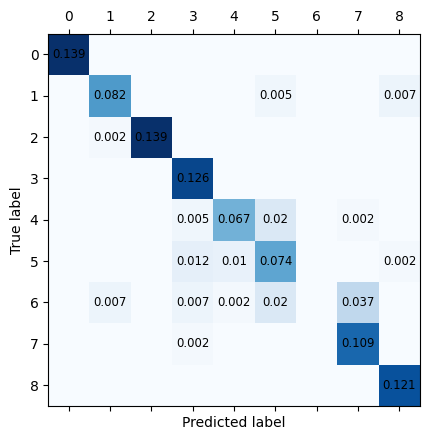

Precision: 0.80, Recall: 0.86, F1: 0.83



In [145]:
val_loss3 =[]
train_loss3 = []

X_train = torch.Tensor(x_train_pca)
y_train = torch.Tensor(y_train)

X_val = torch.Tensor(x_val_pca)
y_val = torch.Tensor(y_val)

X_test = torch.Tensor(x_test_pca)
y_test = torch.Tensor(y_test)

model3 = nn.Sequential(
    nn.Flatten(start_dim=1), 
    nn.Linear(num_features_PCA, 512),  
    nn.ReLU(),

    nn.Linear(512, 256),
    nn.ReLU(), 
    nn.Dropout(0.05),

    nn.Linear(256, 128),
    nn.ReLU(),  
    nn.Dropout(0.02),

    nn.Linear(128, 64), 
    nn.ReLU(),  
    nn.Dropout(0.02),

    nn.Linear(64, 32),
    nn.ReLU(), 

    nn.Linear(32, 16),
    nn.Sigmoid(),  #SIGMOID

    nn.Linear(16, 9), 
)

optimizer = torch.optim.Adadelta(model3.parameters(), lr=0.01)

loss_fn = torch.nn.CrossEntropyLoss()

num_epochs = 60000
patience = 60
best_loss = float('inf')
epochs_no_improve = 0

for n in range(num_epochs):
    # Training
    model.train()
    y_pred = model3(X_train)
    loss = loss_fn(y_pred, y_train.long())
    train_loss3.append(loss.item())  # Append training loss for this epoch
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        y_val_pred = model3(X_val)
        val_loss_epoch = loss_fn(y_val_pred, y_val.long())  # Calculate validation loss for this epoch
        val_loss3.append(val_loss_epoch.item())  # Append validation loss for this epoch

    if n % 10 == 0:
        print(f'Epoch: {n}, Training Loss: {loss.item()}, Validation Loss: {val_loss_epoch.item()}')

    # Early stopping
    if val_loss_epoch < best_loss:
        best_loss = val_loss_epoch
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print('Early stopping!')
            break

print(n, loss.item())

#Testing
model.eval()
test_predictions3 = torch.argmax(model3(X_test), dim=1)

calculate_accuracy_metrics(y_test, test_predictions3)

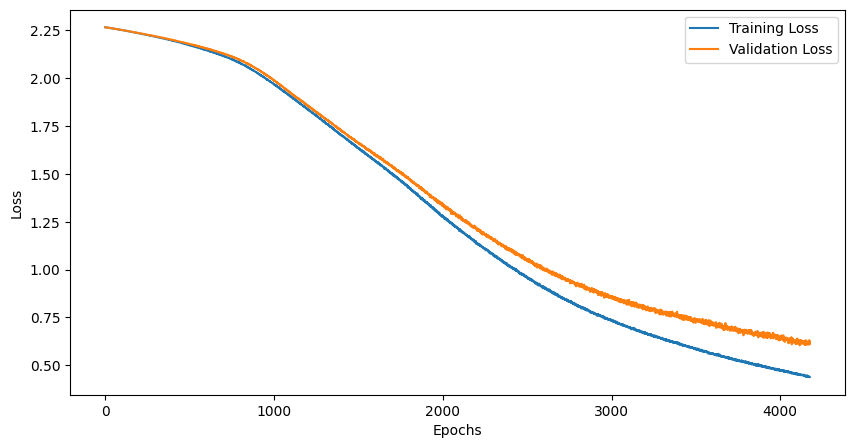

In [146]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss3, label='Training Loss')
plt.plot(val_loss3, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

23% kaggle

# IMPLEMENT CNN

## implement the dataloaders to feed the models

### TVT

In [8]:
# Split the dataset into train, validation, and test 
train_size = int(0.4 * len(dataset))
val_size = int(0.3 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create dataloaders
train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE, shuffle=True)

print(f"Length of train_dataloader: {len(train_dataset)}")
print(f"Length of val_dataloader: {len(val_dataset)}")
print(f"Length of test_dataloader: {len(test_dataset)}")
print(f"***********************************")
print(f'Number of batches in the training set: {int(538/ BATCH_SIZE)}')
print(f'Number of batches in the validation set: {int(403/ BATCH_SIZE)}')
print(f'Number of batches in the test set: {int(405/ BATCH_SIZE)}')

Length of train_dataloader: 538
Length of val_dataloader: 403
Length of test_dataloader: 405
***********************************
Number of batches in the training set: 134
Number of batches in the validation set: 100
Number of batches in the test set: 101


### Implement functions for Train, Validation and Test

the below functions has been adapted from

https://www.youtube.com/watch?v=H69j69FFMV0

In [19]:
def train_one_epoch(dataloader):
  train_loss = 0.0  
  train_accuracy = 0.0
  model.train() 

  for batch_index, data in enumerate(dataloader):
    inputs, labels = data[0].to(device), data[1].to(device)

    optimizer.zero_grad()  # Zero the gradients
    preds = model(inputs)  # Forward pass

    # Compute the number of correct predictions in the batch
    correct = torch.sum(labels == torch.argmax(preds, dim=1)).item()
    # Update the accuracy
    train_accuracy += correct / BATCH_SIZE
    # Compute the loss
    loss = loss_fn(preds, labels)
    # Update the loss
    train_loss += loss.item()

    loss.backward()  # Backward pass
    optimizer.step()  # Perform a single optimization step (parameter update: weights and biases)


  # Compute average loss and accuracy for one epoch
  avg_train_loss = train_loss / len(dataloader)
  avg_train_acc = train_accuracy / len(dataloader)

  # Print loss and acc
  print('Train Loss: {0:.4f}, Train Accuracy: {1:.4f}'.format(avg_train_loss,
                                                            avg_train_acc))
  
  
  # Resets
  train_loss = 0.0  
  train_accuracy = 0.0
  
  return avg_train_loss

def validate_one_epoch(dataloader):
    val_loss = 0.0
    val_accuracy = 0.0
    model.eval()
    
    for i, data in enumerate(dataloader):
        # Move inputs and labels to the device
        inputs, labels = data[0].to(device), data[1].to(device)

        with torch.no_grad():
            # Forward pass
            prediction = model(inputs) 

            # Calculate the number of correct predictions in the batch
            correct = torch.sum(labels == torch.argmax(prediction, dim=1)).item()

            # Update the val accuracy
            val_accuracy += correct / BATCH_SIZE

            # Compute the loss 
            loss = loss_fn(prediction, labels)

            # Update the val loss
            val_loss += loss.item()

    # Compute average loss and accuracy across all batches
    avg_val_loss = val_loss / len(dataloader)
    avg_val_acc = val_accuracy / len(dataloader)

    # Print the validation loss and accuracy
    print('Val Loss: {0:.4f}, Val Accuracy: {1:.4f}'.format(avg_val_loss,
                                                            avg_val_acc))
    print('***************************************************')
    print()
    return val_loss

def test_one_epoch(dataloader):
    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0

    # Initialize lists to store true labels and predictions
    y_true = []
    y_pred = []

    for i, data in enumerate(dataloader):
        inputs, labels = data[0].to(device), data[1].to(device)
        with torch.no_grad():
            # Get the model's predictions.
            outputs = model(inputs)
            # Gets the class with the highest predicted probability for each example in the batch.
            _, predicted = torch.max(outputs, 1)  # Get the predicted classes
            # Calculates the number of correct predictions in the batch.
            correct = torch.sum(labels == predicted).item()
            # Updates the running accuracy by adding the accuracy of the current batch (i.e., the number of correct predictions divided by the batch size).
            running_accuracy += correct / BATCH_SIZE
            # Calculates the loss for the current batch using the specified loss function.
            loss = loss_fn(outputs, labels) # One number, the average batch loss
            # Updates the running loss by adding the loss of the current batch.
            running_loss += loss.item()

        # Append batch predictions and true labels to lists
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

    avg_loss_across_batches = running_loss / len(dataloader)
    avg_acc_across_batches = (running_accuracy / len(dataloader)) * 100
    print('===================================================')

    print('Test Loss: {0:.3f}, Test Accuracy: {1:.1f}%'.format(avg_loss_across_batches,
                                                               avg_acc_across_batches))
    print('***************************************************')
    print()

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate and print accuracy metrics
    calculate_accuracy_metrics(y_true, y_pred)

#function for k fold
def validate_k(dataloader):
    val_loss = 0.0
    val_accuracy = 0.0
    model.eval()

    all_labels = []
    all_predictions = []

    for i, data in enumerate(dataloader):
        # Move inputs and labels to the device
        inputs, labels = data[0].to(device), data[1].to(device)

        with torch.no_grad():
            # Forward pass
            prediction = model(inputs) 

            # Calculate the number of correct predictions in the batch
            correct = torch.sum(labels == torch.argmax(prediction, dim=1)).item()

            # Update the val accuracy
            val_accuracy += correct / BATCH_SIZE

            # Compute the loss 
            loss = loss_fn(prediction, labels)

            # Update the val loss
            val_loss += loss.item()

            # Store the labels and predictions for later use
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(torch.argmax(prediction, dim=1).cpu().numpy())

    # Compute average loss and accuracy across all batches
    avg_val_loss = val_loss / len(dataloader)
    avg_val_acc = val_accuracy / len(dataloader)

    # Print the validation loss and accuracy
    print('Val Loss: {0:.4f}, Val Accuracy: {1:.4f}'.format(avg_val_loss,
                                                            avg_val_acc))
    print('***************************************************')
    print()

    return val_loss, np.array(all_labels), np.array(all_predictions)

## CNN 1

#### TVT dataloaders

In [14]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create dataloaders
train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE, shuffle=True)


# Define the size of each split
k = len(train_dataset) // 5
sizes = [k]*4 + [len(train_dataset) - k*4]

# Create the splits
splits = random_split(train_dataset, sizes)

# Create a DataLoader for each split
dataloaders = [DataLoader(split, batch_size=BATCH_SIZE, shuffle=True) for split in splits]

print(f"Length of train_dataloader: {len(train_dataset)}")
print(f"Length of test_dataloader: {len(test_dataset)}")
print(f"***********************************")
print(f'Number of batches in the training set: {len(train_dataloader)}')
print(f'Number of batches in the test set: {len(test_dataloader)}')

Length of train_dataloader: 1076
Length of test_dataloader: 270
***********************************
Number of batches in the training set: 269
Number of batches in the test set: 68


#### Train the Model

Parametrization inspired from

https://www.kaggle.com/code/cdeotte/how-to-choose-cnn-architecture-mnist

Help with layers compatibility and maxpooling adapted from

https://www.youtube.com/watch?v=H69j69FFMV0

![alt text](<Captura de ecrã 2024-04-07, às 22.56.30.png>)

In [75]:
class CNN(nn.Module):
    def __init__(self, input_channels=3, num_classes=9):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(input_channels, out_channels=128, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=2)
        self.bn4 = nn.BatchNorm2d(1024)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(in_features=9216, out_features=1024)
        self.bn5 = nn.BatchNorm1d(1024)
        self.drop1 = nn.Dropout(0.1)

        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.bn6 = nn.BatchNorm1d(512)
        self.drop2 = nn.Dropout(0.1)

        self.fc3 = nn.Linear(in_features=512, out_features=256)
        self.bn7 = nn.BatchNorm1d(256)
        self.drop3 = nn.Dropout(0.1)

        self.out = nn.Linear(in_features=256, out_features=num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))

        x = self.flatten(x)

        x = self.drop1(F.relu(self.bn5(self.fc1(x))))
        x = self.drop2(F.relu(self.bn6(self.fc2(x))))
        x = self.drop3(F.relu(self.bn7(self.fc3(x))))

        x = self.out(x)

        return x

model = CNN(3,9)


optimizer = torch.optim.Adam(model.parameters(), lr=0.0012)

loss_fn = torch.nn.CrossEntropyLoss()

model = CNN(3,9)
model.to(device)

CNN(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(512, 1024, kernel_size=(2, 2), stride=(1, 1))
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_d

In [76]:
for i, data in enumerate(train_dataloader):
    inputs, labels = data[0].to(device), data[1].to(device)
    print(f'input shape: {inputs.shape}')
    print(f'after network shape: {model(inputs).shape}')
    break

input shape: torch.Size([4, 3, 75, 75])
after network shape: torch.Size([4, 9])


In [77]:
num_params = 0
for x in model.parameters():
  num_params += len(torch.flatten(x))

print(f'Number of parameters in the model: {num_params:,}')

Number of parameters in the model: 13,681,161


For Epoch: 1

Train Loss: 0.0272, Train Accuracy: 0.9907
Val Loss: 0.0018, Val Accuracy: 0.9975
***************************************************

For Epoch: 2

Train Loss: 0.0418, Train Accuracy: 0.9907
Val Loss: 0.0016, Val Accuracy: 0.9975
***************************************************

For Epoch: 3

Train Loss: 0.0641, Train Accuracy: 0.9852
Val Loss: 0.0024, Val Accuracy: 0.9975
***************************************************

For Epoch: 4

Train Loss: 0.0141, Train Accuracy: 0.9907
Val Loss: 0.0048, Val Accuracy: 0.9950
***************************************************

For Epoch: 5

Train Loss: 0.0034, Train Accuracy: 0.9963
Val Loss: 0.0029, Val Accuracy: 0.9975
***************************************************

For Epoch: 6

Train Loss: 0.0015, Train Accuracy: 0.9963
Val Loss: 0.0031, Val Accuracy: 0.9975
***************************************************

For Epoch: 7

Train Loss: 0.0213, Train Accuracy: 0.9926
Val Loss: 0.0029, Val Accuracy: 0.9975
**********

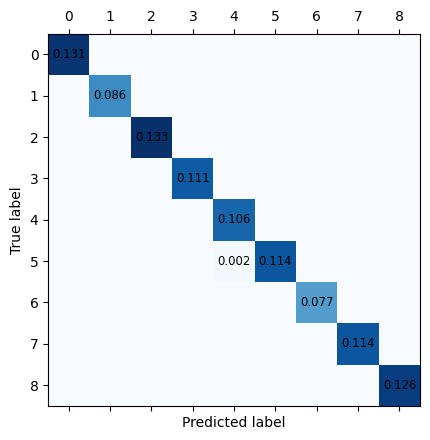

Precision: 1.00, Recall: 1.00, F1: 1.00

Finished Training


In [ ]:
train_losses = []
val_losses = []

optimizer = torch.optim.Adam(model.parameters(), lr=0.0012) 
loss_fn = torch.nn.CrossEntropyLoss()

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

num_epochs = 500
patience = 50
best_loss = float('inf')

for epoch_index in range(num_epochs):
    print(f'For Epoch: {epoch_index + 1}\n')

    train_loss = train_one_epoch(train_dataloader) # TRAIN
    train_losses.append(train_loss)

    val_loss = validate_one_epoch(val_dataloader) # VALIDATION
    val_losses.append(val_loss)

    # Early Stop
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth') #Save parameters with lowest Val loss
        no_improve = 0  # reset the count
    else:
        no_improve += 1
    # Check for early stopping
    if no_improve >= patience:
        print("Early stopping")
        break

test_one_epoch(test_dataloader)  # TEST

print('Finished Training')

In [20]:
export_preds(test_dataset_loader, model, labels)

,ID,TARGET
0,1,12
1,2,50
2,3,39
3,4,6
4,5,24
...,...,...
305,306,6
306,307,44
307,308,24
308,309,44


## CNN 2 RMS prop

#### TVT dataloader

In [86]:
# Create x and y tensors
x, y = zip(*[(img, label) for img, label in dataset])
x = torch.stack(x)
y = torch.tensor(y)

# Split data into train, validation, and test sets (40%-30%-30%)
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, stratify=y, test_size=0.3)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, stratify=y_train_val, test_size=0.42857)

# Print the shapes
print("Split Sizes TVT (40%-30%-30%):")
print(f"Train: {x_train.shape}, {y_train.shape}")
print(f"Validation: {x_val.shape}, {y_val.shape}")
print(f"Test: {x_test.shape}, {y_test.shape}")

def convert_and_one_hot_encode(y, num_classes):
    y_tensor = torch.Tensor(y).long()
    return torch.nn.functional.one_hot(y_tensor, num_classes).float()

num_classes = 9 

y_train1 = convert_and_one_hot_encode(y_train, num_classes)
y_val1 = convert_and_one_hot_encode(y_val, num_classes)
y_test1 = convert_and_one_hot_encode(y_test, num_classes)

X_train = torch.Tensor(x_train)
X_val = torch.Tensor(x_val)
X_test = torch.Tensor(x_test)


Split Sizes TVT (40%-30%-30%):
Train: torch.Size([538, 3, 75, 75]), torch.Size([538])
Validation: torch.Size([404, 3, 75, 75]), torch.Size([404])
Test: torch.Size([404, 3, 75, 75]), torch.Size([404])


#### Train the Model

In [87]:
class CNN(nn.Module):
    def __init__(self, input_channels=3, num_classes=9):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.fc1 = nn.Linear(128*8*8, 512)
        self.dropout = nn.Dropout(0.1)

        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        
        x = x.view(x.size(0), -1)  # Flatten
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)

        x = self.fc2(x)
        return x

    
model = CNN(3,9)
model = model.to(device)


In [88]:
num_params = 0
for x in model.parameters():
  num_params += len(torch.flatten(x))

print(f'Number of parameters in the model: {num_params:,}')

Number of parameters in the model: 4,293,129


In [89]:
val_loss2 =[]
train_loss2 = []


optimizer = torch.optim.RMSprop(model.parameters(), lr=0.00002)
loss_fn = torch.nn.MSELoss()

num_epochs = 10000
patience = 10
best_loss = float('inf')
epochs_no_improve = 0

for n in range(num_epochs):
    # Training
    model.train()
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train1) 
    train_loss2.append(loss.item())  # Append training loss for this epoch
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val)
        val_loss_epoch = loss_fn(y_val_pred, y_val1)  # No need to convert to long
        val_loss2.append(val_loss_epoch.item())  # Append validation loss for this epoch

    if n % 10 == 0:
        print(f'Epoch: {n}, Training Loss: {loss.item()}, Validation Loss: {val_loss_epoch.item()}')

    # Early stopping
    if val_loss_epoch < best_loss:
        best_loss = val_loss_epoch
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print('Early stopping!')
            break

print(n, loss.item())

#Testing
model.eval()
test_predictions2 = torch.argmax(model(X_test), dim=1).float()  # Convert to float

# Convert y_test to the same format as test_predictions2
y_test_argmax = torch.argmax(y_test1, dim=1)

print("Confusion Matrix\n", confusion_matrix(y_test_argmax, test_predictions2))
print("Accuracy: %.2f %%" % (accuracy_score(y_test_argmax, test_predictions2) * 100))

#Testing
model.eval()
test_predictions2 = torch.argmax(model(x_test), dim=1).float()  # Convert to float

# Convert y_test to the same format as test_predictions2
y_test_argmax = torch.argmax(y_test1, dim=1)

calculate_accuracy_metrics(y_test_argmax, test_predictions2)

Epoch: 0, Training Loss: 0.2156631052494049, Validation Loss: 0.12541355192661285


KeyboardInterrupt: 

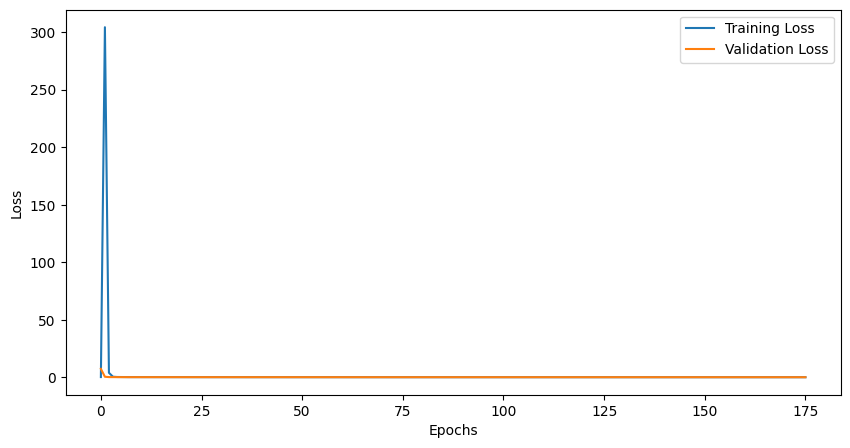

In [172]:
plt.figure(figsize=(10, 5))
plt.plot(train_loss2, label='Training Loss')
plt.plot(val_loss2, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Transfer learning efficientnet-b3

https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b3.html

![alt text](b3.png)




In [158]:
!pip3 install efficientnet_pytorch

Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=577d051493d68c3a4846f3c479920c8d9bbd87860e4a6e69e1e057d0a9ce487d
  Stored in directory: /Users/josenamora/Library/Caches/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
Successfully built efficientnet_pytorch


Loaded pretrained weights for efficientnet-b3
For Epoch: 1

Train Loss: 1.4346, Train Accuracy: 0.5241
Val Loss: 1.7967, Val Accuracy: 0.5495
***************************************************

For Epoch: 2

Train Loss: 1.0778, Train Accuracy: 0.6204
Val Loss: 0.9329, Val Accuracy: 0.8218
***************************************************

For Epoch: 3

Train Loss: 0.7279, Train Accuracy: 0.7704
Val Loss: 0.5475, Val Accuracy: 0.8465
***************************************************

For Epoch: 4

Train Loss: 0.5559, Train Accuracy: 0.8370
Val Loss: 1.1546, Val Accuracy: 0.7550
***************************************************

For Epoch: 5

Train Loss: 0.3215, Train Accuracy: 0.9167
Val Loss: 0.4828, Val Accuracy: 0.8564
***************************************************

For Epoch: 6

Train Loss: 0.2716, Train Accuracy: 0.9259
Val Loss: 0.7671, Val Accuracy: 0.8168
***************************************************

For Epoch: 7

Train Loss: 0.1088, Train Accuracy: 0.9648
Val

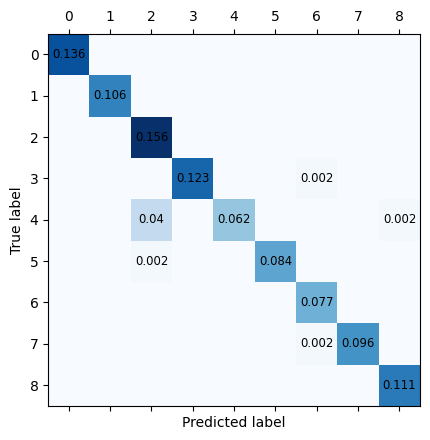

Precision: 0.96, Recall: 0.95, F1: 0.95

Finished Training


In [ ]:
from efficientnet_pytorch import EfficientNet


model = EfficientNet.from_pretrained('efficientnet-b3')

# Apply transfer learning
num_classes = 9
model._fc = torch.nn.Linear(model._fc.in_features, num_classes) #unfreeze last layer

model = model.to(device)

train_losses = []
val_losses = []

optimizer = torch.optim.Adam(model.parameters(), lr=0.0012)
loss_fn = torch.nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

num_epochs = 40
patience = 20
best_loss = float('inf')

for epoch_index in range(num_epochs):
    print(f'For Epoch: {epoch_index + 1}\n')

    train_loss = train_one_epoch(train_dataloader) # TRAIN
    train_losses.append(train_loss)

    val_loss = validate_one_epoch(val_dataloader) # VALIDATION
    val_losses.append(val_loss)

    # Early Stop
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth') 
        no_improve = 0  # reset the count
    else:
        no_improve += 1
    # Check for early stopping
    if no_improve >= patience:
        print("Early stopping")
        break

test_one_epoch(test_dataloader)  # TEST

print('Finished Training')

# Reproducing Kaggle Results

In [9]:
class CNN(nn.Module):
    def __init__(self, input_channels=3, num_classes=9):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(input_channels, out_channels=128, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=2)
        self.bn4 = nn.BatchNorm2d(1024)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(in_features=9216, out_features=1024)
        self.bn5 = nn.BatchNorm1d(1024)
        self.drop1 = nn.Dropout(0.1)

        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.bn6 = nn.BatchNorm1d(512)
        self.drop2 = nn.Dropout(0.1)

        self.fc3 = nn.Linear(in_features=512, out_features=256)
        self.bn7 = nn.BatchNorm1d(256)
        self.drop3 = nn.Dropout(0.1)

        self.out = nn.Linear(in_features=256, out_features=num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.pool4(F.relu(self.bn4(self.conv4(x))))

        x = self.flatten(x)

        x = self.drop1(F.relu(self.bn5(self.fc1(x))))
        x = self.drop2(F.relu(self.bn6(self.fc2(x))))
        x = self.drop3(F.relu(self.bn7(self.fc3(x))))

        x = self.out(x)

        return x

model = CNN(3,9)


optimizer = torch.optim.Adam(model.parameters(), lr=0.0012)

loss_fn = torch.nn.CrossEntropyLoss()

model = CNN(3,9)
model.to(device)

CNN(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(512, 1024, kernel_size=(2, 2), stride=(1, 1))
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_d

In [10]:
# Load the weights from the saved file
model.load_state_dict(torch.load('best model weights/best_model-99.pth', map_location=torch.device('cpu')))

# Set the model to evaluation mode
model.eval()

CNN(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(512, 1024, kernel_size=(2, 2), stride=(1, 1))
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_d

In [18]:
export_preds(test_dataset_loader, model, labels)

,ID,TARGET
0,1,12
1,2,50
2,3,39
3,4,6
4,5,24
...,...,...
305,306,6
306,307,38
307,308,24
308,309,38
